# 7. K-VECINOS MÁS CERCANOS (K-NEAREST NEIGHBORS)


1. Introducción y formulación matemática
2. Clasificación con k-NN (binaria y multiclase)
3. Normalización y estandarización
4. Regresión con k-NN
5. Implementación desde cero (brute-force)
6. Selección de $k$ y validación

Herramientas: `numpy`, `pandas`, `scikit-learn`, `matplotlib`, `seaborn`.

## 1. Introducción y formulación matemática

K-NN es un método no paramétrico basado en la proximidad: una observación se clasifica o predice según los $k$ vecinos más cercanos en el espacio de características.

Sea $X = \{x_1,\dots,x_n\}$ con etiquetas $Y = \{y_1,\dots,y_n\}$. Para una nueva observación $x^*$ definimos el conjunto $N_k(x^*)$ de sus $k$ vecinos más cercanos según una métrica de distancia $d(\cdot,\cdot)$ (usualmente Euclidiana).\

Para clasificación binaria (etiquetas en $\{0,1\}$), la regla de decisión es por mayoría:
\begin{equation}
\hat{y}(x^*) = \mathbf{1}\left( \sum_{x_i \in N_k(x^*)} y_i \ge \frac{k}{2} \right).
\end{equation}

Para regresión la predicción es el promedio (o ponderación) de los valores de los vecinos:
\begin{equation}
\hat{y}(x^*) = \frac{1}{k} \sum_{x_i \in N_k(x^*)} y_i \quad \text{o con pesos } w_i \propto \frac{1}{d(x_i,x^*)}.
\end{equation}

La elección de la métrica $d$ y de $k$ controla el sesgo-varianza del estimador: $k$ pequeño → baja sesgo, alta varianza; $k$ grande → mayor sesgo, baja varianza.

## 2. Clasificación con k-NN: clasificación binaria (teoría + ejemplo)

Usaremos el dataset sintético `make_moons` para ilustrar comportamiento y fronteras de decisión. Mostraremos la regla de mayoría y una variante con ponderación por distancia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set()

# Datos sintéticos (binario)
X, y = make_moons(n_samples=400, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Normalizar características antes de KNN (recomendado)
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

# Clasificador k-NN (k=5, distancia Euclidiana)
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(Xtr_s, y_train)
y_pred = knn.predict(Xte_s)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        59
           1       0.96      0.90      0.93        61

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120



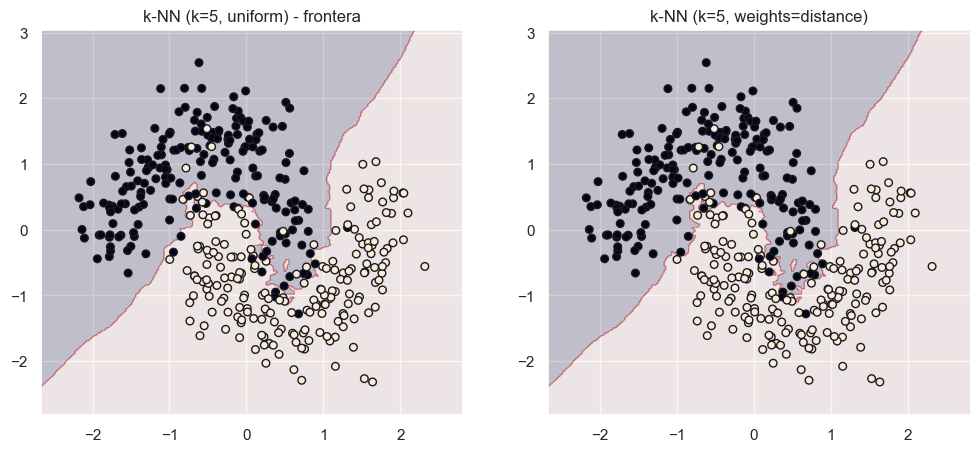

In [2]:
# Visualizar frontera de decisión
def plot_decision_boundary(model, X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y, s=30, edgecolor='k')
    if title:
        ax.set_title(title)
    return ax

fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_decision_boundary(knn, scaler.transform(X), y, ax=ax[0], title='k-NN (k=5, uniform) - frontera')

# Con pesos inversos a la distancia
knn_weighted = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_weighted.fit(Xtr_s, y_train)
plot_decision_boundary(knn_weighted, scaler.transform(X), y, ax=ax[1], title='k-NN (k=5, weights=distance)')
plt.show()

## 3. Normalización y Estandarización

K-NN depende de distancias; por eso es crucial que las features estén en escalas comparables. Dos transformaciones comunes:

- Normalización min-max: $x' = \dfrac{x - x_{min}}{x_{max} - x_{min}}$ (escala $[0,1]$).
- Estandarización (z-score): $x' = \dfrac{x - \mu}{\sigma}$ (media 0, desviación estándar 1).

En general la estandarización es la más usada para K-NN. A continuación mostramos efectos de no escalar vs escalar en el dataset Iris.

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

iris = load_iris()
X_iris, y_iris = iris.data[:, :2], iris.target  # seleccionamos solo 2 features para visualizar

knn_raw = KNeighborsClassifier(n_neighbors=5)
scores_raw = cross_val_score(knn_raw, X_iris, y_iris, cv=5, scoring='accuracy')

scaler_std = StandardScaler().fit(X_iris)
X_std = scaler_std.transform(X_iris)
scores_std = cross_val_score(knn_raw, X_std, y_iris, cv=5, scoring='accuracy')

scaler_mm = MinMaxScaler().fit(X_iris)
X_mm = scaler_mm.transform(X_iris)
scores_mm = cross_val_score(knn_raw, X_mm, y_iris, cv=5, scoring='accuracy')

print('CV Accuracy (raw):', np.round(scores_raw,4).tolist())
print('CV Accuracy (standardized):', np.round(scores_std,4).tolist())
print('CV Accuracy (min-max):', np.round(scores_mm,4).tolist())

CV Accuracy (raw): [0.7333, 0.7667, 0.7667, 0.8667, 0.7333]
CV Accuracy (standardized): [0.7333, 0.8, 0.8, 0.9333, 0.7]
CV Accuracy (min-max): [0.7, 0.8, 0.7667, 0.8667, 0.7333]


## 4. Una primera aplicación (Iris): clasificación multiclase

Usaremos las cuatro features de Iris, validación cruzada y búsqueda de $k$ óptimo mediante validación.

Best params: {'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
Best CV accuracy: 0.9666666666666668


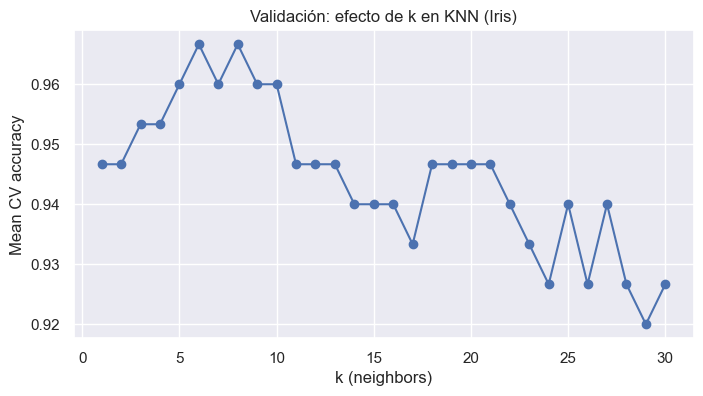

In [6]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X, y = load_iris(return_X_y=True)
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': list(range(1,31)), 'knn__weights': ['uniform','distance']}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', grid.best_score_)

# Curva de validación del parámetro k (uniform)
results = pd.DataFrame(grid.cv_results_)
subset = results[results['param_knn__weights']=='uniform']
plt.figure(figsize=(8,4))
plt.plot(subset['param_knn__n_neighbors'].astype(int), subset['mean_test_score'], marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('Mean CV accuracy')
plt.title('Validación: efecto de k en KNN (Iris)')
plt.grid(True)
plt.show()

## 5. Regresión con k-NN (teoría y ejemplo)

En regresión, la predicción para $x^*$ es un promedio de los vecinos:
\begin{equation}
\hat{y}(x^*) = \frac{1}{k} \sum_{x_i \in N_k(x^*)} y_i
\end{equation}

O con pesos inversos a la distancia:
\begin{equation}
\hat{y}(x^*) = \frac{\sum_{x_i \in N_k(x^*)} w_i y_i}{\sum_{x_i \in N_k(x^*)} w_i}, \quad w_i = \frac{1}{d(x_i,x^*) + \epsilon}.
\end{equation}

Mostraremos un ejemplo con `make_regression` y `KNeighborsRegressor`.

MSE (k-NN reg): 284.2199572539029


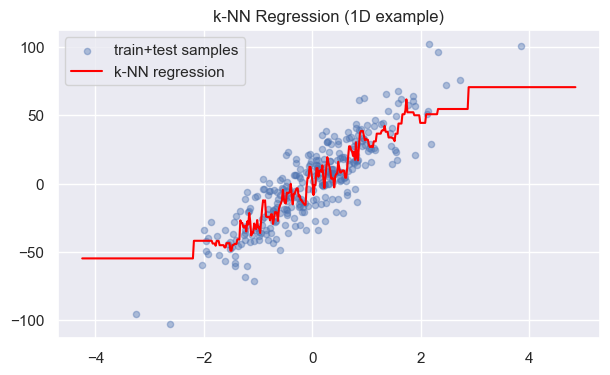

In [7]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

Xr, yr = make_regression(n_samples=300, n_features=1, noise=15.0, random_state=42)
Xtr, Xte, ytr, yte = train_test_split(Xr, yr, test_size=0.3, random_state=42)
scaler_r = StandardScaler().fit(Xtr)
Xtr_s = scaler_r.transform(Xtr)
Xte_s = scaler_r.transform(Xte)

knn_reg = KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_reg.fit(Xtr_s, ytr)
y_pred_r = knn_reg.predict(Xte_s)
print('MSE (k-NN reg):', mean_squared_error(yte, y_pred_r))

# Visualización
xx = np.linspace(Xr.min()-1, Xr.max()+1, 500).reshape(-1,1)
xx_s = scaler_r.transform(xx)
yy_grid = knn_reg.predict(xx_s)
plt.figure(figsize=(7,4))
plt.scatter(Xr, yr, s=20, alpha=0.4, label='train+test samples')
plt.plot(xx, yy_grid, color='red', label='k-NN regression')
plt.legend()
plt.title('k-NN Regression (1D example)')
plt.show()

## 6. Ejemplo ilustrativo: efecto de $k$ en regresión (bias-variance)

Mostramos cómo varía el MSE en test cuando variamos $k$.

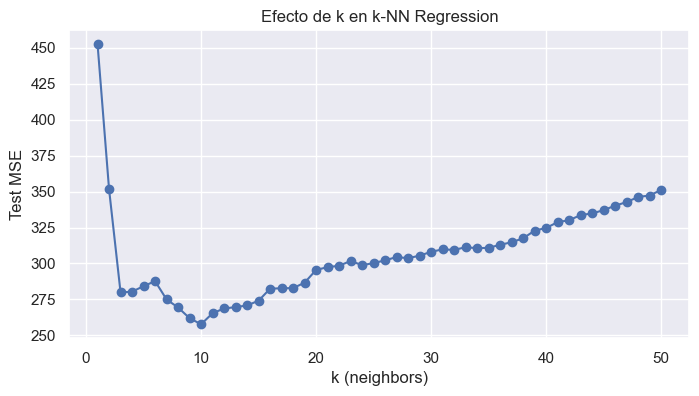

In [8]:
ks = list(range(1,51))
mse_vals = []
for k in ks:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(Xtr_s, ytr)
    yp = model.predict(Xte_s)
    mse_vals.append(mean_squared_error(yte, yp))

plt.figure(figsize=(8,4))
plt.plot(ks, mse_vals, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('Test MSE')
plt.title('Efecto de k en k-NN Regression')
plt.grid(True)
plt.show()

## 7. Implementación del modelo k-vecinos más cercanos (brute-force) — desde cero

A continuación implementamos una versión simple sin optimizaciones (sin KD-tree). Usaremos distancia Euclidiana y búsqueda de $k$ vecinos por fuerza bruta.

Esta implementación es útil para entender la lógica y para propósitos pedagógicos.

In [9]:
class KNNBrute:
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        assert weights in ('uniform','distance')
        self.weights = weights
    def fit(self, X, y):
        self.X_ = np.asarray(X)
        self.y_ = np.asarray(y)
        return self
    def _distances(self, Xq):
        # retorna matriz (n_queries, n_train) de distancias Euclidianas
        Xq = np.atleast_2d(Xq)
        dists = np.sqrt(((Xq[:, None, :] - self.X_[None, :, :])**2).sum(axis=2))
        return dists
    def predict(self, Xq):
        dists = self._distances(Xq)
        nq = dists.shape[0]
        preds = []
        for i in range(nq):
            idx = np.argsort(dists[i])[:self.n_neighbors]
            neighbors_y = self.y_[idx]
            if self.weights == 'uniform':
                # clasificación multi/clase por mayoría
                values, counts = np.unique(neighbors_y, return_counts=True)
                preds.append(values[np.argmax(counts)])
            else:
                # weights = distance
                w = 1.0 / (dists[i, idx] + 1e-8)
                # si y es continuo (regresión) usamos promedio ponderado
                if np.issubdtype(self.y_.dtype, np.number) and len(np.unique(self.y_))>10:
                    preds.append(np.dot(w, neighbors_y)/w.sum())
                else:
                    # para clasificación, sumamos pesos por clase
                    classes = np.unique(neighbors_y)
                    score = {c: 0.0 for c in classes}
                    for cls, ww in zip(neighbors_y, w):
                        score[cls] += ww
                    preds.append(max(score.items(), key=lambda x: x[1])[0])
        return np.array(preds)
    def predict_reg(self, Xq):
        dists = self._distances(Xq)
        nq = dists.shape[0]
        preds = []
        for i in range(nq):
            idx = np.argsort(dists[i])[:self.n_neighbors]
            neighbors_y = self.y_[idx]
            if self.weights == 'uniform':
                preds.append(neighbors_y.mean())
            else:
                w = 1.0 / (dists[i, idx] + 1e-8)
                preds.append(np.dot(w, neighbors_y)/w.sum())
        return np.array(preds)

# Probar implementación en Iris (usando las dos primeras features para visualizar)
Xv = load_iris().data[:, :2]
yv = load_iris().target
Xtr, Xte, ytr, yte = train_test_split(Xv, yv, test_size=0.3, random_state=42)
knn_b = KNNBrute(n_neighbors=5, weights='uniform').fit(Xtr, ytr)
yp = knn_b.predict(Xte)
print('Accuracy (KNNBrute, iris 2D):', accuracy_score(yte, yp))

Accuracy (KNNBrute, iris 2D): 0.8


## 8. Selección de $k$ y validación (práctica recomendada)

Se recomienda escoger $k$ mediante validación cruzada y observar la curva de validación. También evaluar efectos de la métrica (Euclidiana, Manhattan) y de la ponderación.

A modo de resumen: K-NN es sencillo, interpretativo y eficaz en problemas con estructuras locales, pero no escala bien a datasets grandes sin aceleraciones (KD-tree, Ball-tree) y es sensible a la escala de las variables.

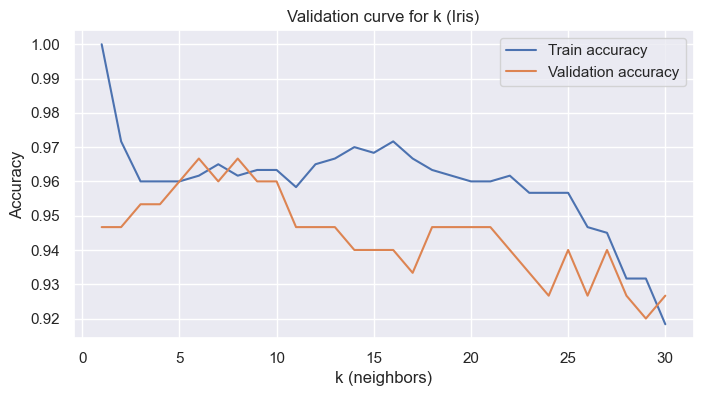

In [10]:
# Curva de validación para K en Iris (usando StandardScaler)
from sklearn.model_selection import validation_curve

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_range = np.arange(1, 31)
train_scores, test_scores = validation_curve(pipe, X, y, param_name='knn__n_neighbors', param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,4))
plt.plot(param_range, train_mean, label='Train accuracy')
plt.plot(param_range, test_mean, label='Validation accuracy')
plt.xlabel('k (neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation curve for k (Iris)')
plt.grid(True)
plt.show()

## 9. Notas finales y referencias

- K-NN es un método instanciero: no produce un modelo paramétrico compacto (la «fase de entrenamiento» consiste en almacenar los datos).  
- Acelerar búsqueda de vecinos: KD-tree, Ball-tree, hashing (approximate).  
- Para datos de alta dimensión la noción de «cercanía» puede degradarse (maldición de la dimensionalidad); considerar reducción de dimensionalidad antes de aplicar K-NN.  

### Referencias
- Hastie, T., Tibshirani, R., Friedman, J. (2009). *The Elements of Statistical Learning*. Capítulo sobre métodos instance-based.  
- Duda, R. O., Hart, P. E., & Stork, D. G. (2001). *Pattern Classification*.
